# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(1)

Now, we load the train and validation sets.

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
valid_df = pd.read_csv('perplejidad/datasets/validation_train_set.csv',delimiter='\t')

In [5]:
len(train_df),len(valid_df)

(33684, 3743)

In [6]:
train_df['is_valid']=False

In [7]:
valid_df['is_valid']=True

In [8]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [9]:
train_idxs, valid_idxs = L(range(len(train_valid_df[train_valid_df.is_valid==False]))), L(range(len(train_valid_df[train_valid_df.is_valid==False]), len(train_valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [10]:
dl_kwargs = {"bs": 96, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [11]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Mother tongue",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [12]:
learn = learn.to_fp16()

In [13]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"Tengo muchos libros y novels que le gustan mucho l'insupportable_legerete_de_l_etre de Milan_Kundera, mille_et_un_soleils_splendides , je_ne_suis_pas_celle_que_je_suis de una irani escritora e un libro de un escritor español Javier_Marias Un_Coeur_si_blanc ...",Árabe
1,"Pes estabamos en el kamra esperando un taxi de_repente pasó a+mi a+mi lado un homdre bien vestido preguntando la dirección+de dirección+de el hospita ibn_sina, de_repente se fue y me entere+qe entere+qe me habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera",Árabe
2,"Aquí es mi número de teléfono+:+18270918681+.+Por_favor teléfono+:+18270918681+.+Por_favor teléfono+:+18270918681+.+Por_favor teléfono+:+18270918681+.+Por_favor teléfono+:+18270918681+.+Por_favor, puede llamar me por eso.",Chino mandarín
3,"Mi hermano mayor tiene treinta_y_ocho años de edad y se llama Laércio, despúes de él tiene Anatiana con treinta_y_seis, luego en_seguida Luiziana con treinta_y_cuatro años, yo con treinta_y_dos años y por_fin Girlana con treinta_y_uno anõs.",Portugués
4,"Mañana, voy a visitar la Baïxa y la Plaça_del_Commercio y despuès, iré a la Torre_de_Belém, a el monumento_de_los_Navigatores y tambien a el Monasterio_de_los_Geronimos que es cerca de los.!",Francés


In [14]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.698389,1.703968,0.278921,00:24


epoch,train_loss,valid_loss,accuracy,time
0,1.403845,1.404719,0.441892,00:39
1,1.245890,1.350138,0.492653,00:40
2,1.023657,1.382321,0.481699,00:40
3,0.567221,1.596954,0.505477,00:39
4,0.299486,2.006468,0.522308,00:41
5,0.158138,2.476154,0.522308,00:41
6,0.073221,2.817118,0.505477,00:38
7,0.025296,3.383096,0.516698,00:41
8,0.007409,3.855285,0.522843,00:40
9,0.000731,3.952229,0.523110,00:40


In [15]:
learn.export('roberta-mother-tonge.pkl')

In [16]:
learn.save('roberta-mother-tonge')

Path('models/roberta-mother-tonge.pth')

In [17]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [18]:
test_df['is_valid']=True

In [19]:
train_test_df = pd.concat([train_df,test_df])

In [20]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [21]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Mother tongue",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [22]:
learnTest.load('roberta-mother-tonge')

In [23]:
learnTest.validate()

(#2) [3.8827602863311768,0.5247408151626587]

In [24]:
from fastai.interpret import *

In [25]:
preds,gt=learnTest.get_preds()

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learn.dls.vocab)

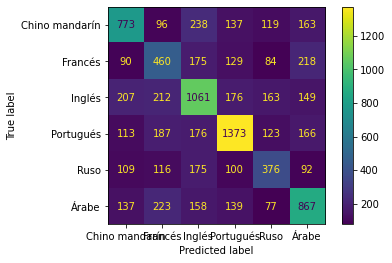

In [29]:
disp.plot()